## Goal of notebook

This notebook accompanies [sSVN](https://github.com/leviyevalex/sSVN), and provides an example of how to run on the hybrid Rosenbrock. The hybrid Rosenbrock is a very convenient benchmark.
1. It is easily adapted to any number of dimensions $D \ge 2$.
2. Each marginal is a long and narrow ridge. These are notoriously difficult for sampling algorithms to resolve.
3. It may be analytically sampled, providing a computationally trivial way to compare the quality of samples obtained via various methods/algorithms.
4. Most importantly, it closely resembles many geometries often encountered in practice (e.g, https://arxiv.org/abs/2106.15163).

In this notebook we compare the performance of SVGD and sSVN on a ten-dimensional hybrid Rosenbrock. We encourage the reader to tinker with the settings of the hybrid Rosenbrock, `eps`, and `nParticles`. The reader will find that sSVN is much more stable than sSVGD. That is, sSVN may be evolved with a much larger `eps`.

## Import tools

In [1]:
import sys
sys.path.append("..")

from models.JAXHRD import hybrid_rosenbrock
from models.multivariate_gaussian import multivariate_gaussian
from src.samplers import samplers
from scripts.plot_helper_functions import collect_samples
import numpy as np
%matplotlib inline
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
import corner

In [2]:
from jax import random
import jax.numpy as jnp
x = random.uniform(random.PRNGKey(0), (1000,), dtype=jnp.float64)
x.dtype






dtype('float64')

In [ ]:
2 / 2 ** 2

## Setup hybrid Rosenbrock model

In [ ]:
# Hybrid Rosenbrock
n2 = 3
n1 = 4
DoF = n2 * (n1 - 1) + 1
B = np.zeros(DoF)
B[0] = 30
B[1:] = 20
mu=1
model = hybrid_rosenbrock(n2, n1, mu, B)
ground_truth = model.newDrawFromPosterior(100000)

In [2]:
# Gaussian
DoF = 10
mu = np.zeros(DoF)
# sigma = np.random.uniform(low=1, high=10, size=DoF) # covariance matrix
sigma = np.ones(DoF) * 3
model = multivariate_gaussian(mu, sigma)
ground_truth_samples = model.newDrawFromLikelihood(10000000)

In [3]:
truth_table = ((ground_truth_samples > model.lower_bound) & (ground_truth_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = ground_truth_samples[idx]

576762 samples obtained from rejection sampling


In [ ]:
corner.corner(bounded_iid_samples)

In [ ]:
# UNIT tests (boundary)

# 1 - Map acting on a single particle in several dimensions
lower = np.array([-2, 1])
upper = np.array([4, 5])

x = np.array([2, 2.1]) # In the bounded domain

x_  = sampler1._F(x, lower, upper) # Goes into unbounded domain
x__ = sampler1._F_inv(x_, lower, upper) # Undo transformation

print(np.allclose(x, x__))

# 2 - Map acting on three particles in several dimensions

X = np.array([[1.0, 2.0],
              [1.2, 2.2],
              [1.3, 2.3]])



X_  = sampler1._F(X, lower, upper) # Goes into unbounded domain
X__ = sampler1._F_inv(X_, lower, upper) # Undo transformation

print(np.allclose(x, x__))

# 3 - With Gaussian particles

lower = model.lower_bound
upper = model.upper_bound
particle = ground_truth_samples[0:5]
X = sampler1._F_inv(particle, lower, upper)
Y = sampler1._F(X, lower, upper)
np.allclose(Y, particle)






In [ ]:
# Do the map derivatives agree with each other? - YES

from jax import grad, jacobian
import jax.numpy as jnp

def _F_inv(Y, a, b):
    return (a + b * jnp.exp(Y)) / (1 + jnp.exp(Y))

test1 = jacobian(_F_inv)(particle[0], jnp.array(lower), jnp.array(upper))[jnp.array(range(10)), jnp.array(range(10))]
test2 = sampler1._dF_inv(particle[0], lower, upper)

print(np.allclose(test1, test2))

test3 = jacobian(jacobian(_F_inv))(particle[0], jnp.array(lower), jnp.array(upper))[jnp.array(range(10)), jnp.array(range(10)), jnp.array(range(10))]
test4 = sampler1._diagHessF_inv(particle[0], lower, upper)

print(np.allclose(test3, test4))

## Run sSVGD dynamics

Remark: sSVGD is unstable with eps=0.01. Try it!

In [4]:
nParticles = 100
# kernelKwargs = {'kernel_type': 'RBF', 'nFeatures':nParticles}
kernelKwargs = {'h':model.DoF * 10, 'p':1.} # RBF
# kernelKwargs = {'h':model.DoF, 'p':0.5} # Lp
sampler1 = samplers(model=model, nIterations=300, nParticles=nParticles, profile=False, kernel_type='Lp')
sampler1.apply(method='sSVN', eps=1, kernelKwargs=kernelKwargs)

  0%|          | 0/300 [00:01<?, ?it/s]
ERROR:src.samplers:Error occurred in apply()
Traceback (most recent call last):
  File "/mnt/c/sSVN_GW/notebooks/../src/samplers.py", line 159, in apply
    kx, gkx1 = self.__getKernelWithDerivatives_(X, kernelKwargs)
  File "/mnt/c/sSVN_GW/notebooks/../src/samplers.py", line 510, in __getKernelWithDerivatives_
    kx, gkx1 = self._getKernelWithDerivatives(Y, params)
  File "/mnt/c/sSVN_GW/notebooks/../src/JAX_kernels.py", line 82, in getKernelWithDerivatives
    raise NotImplementedError()
NotImplementedError


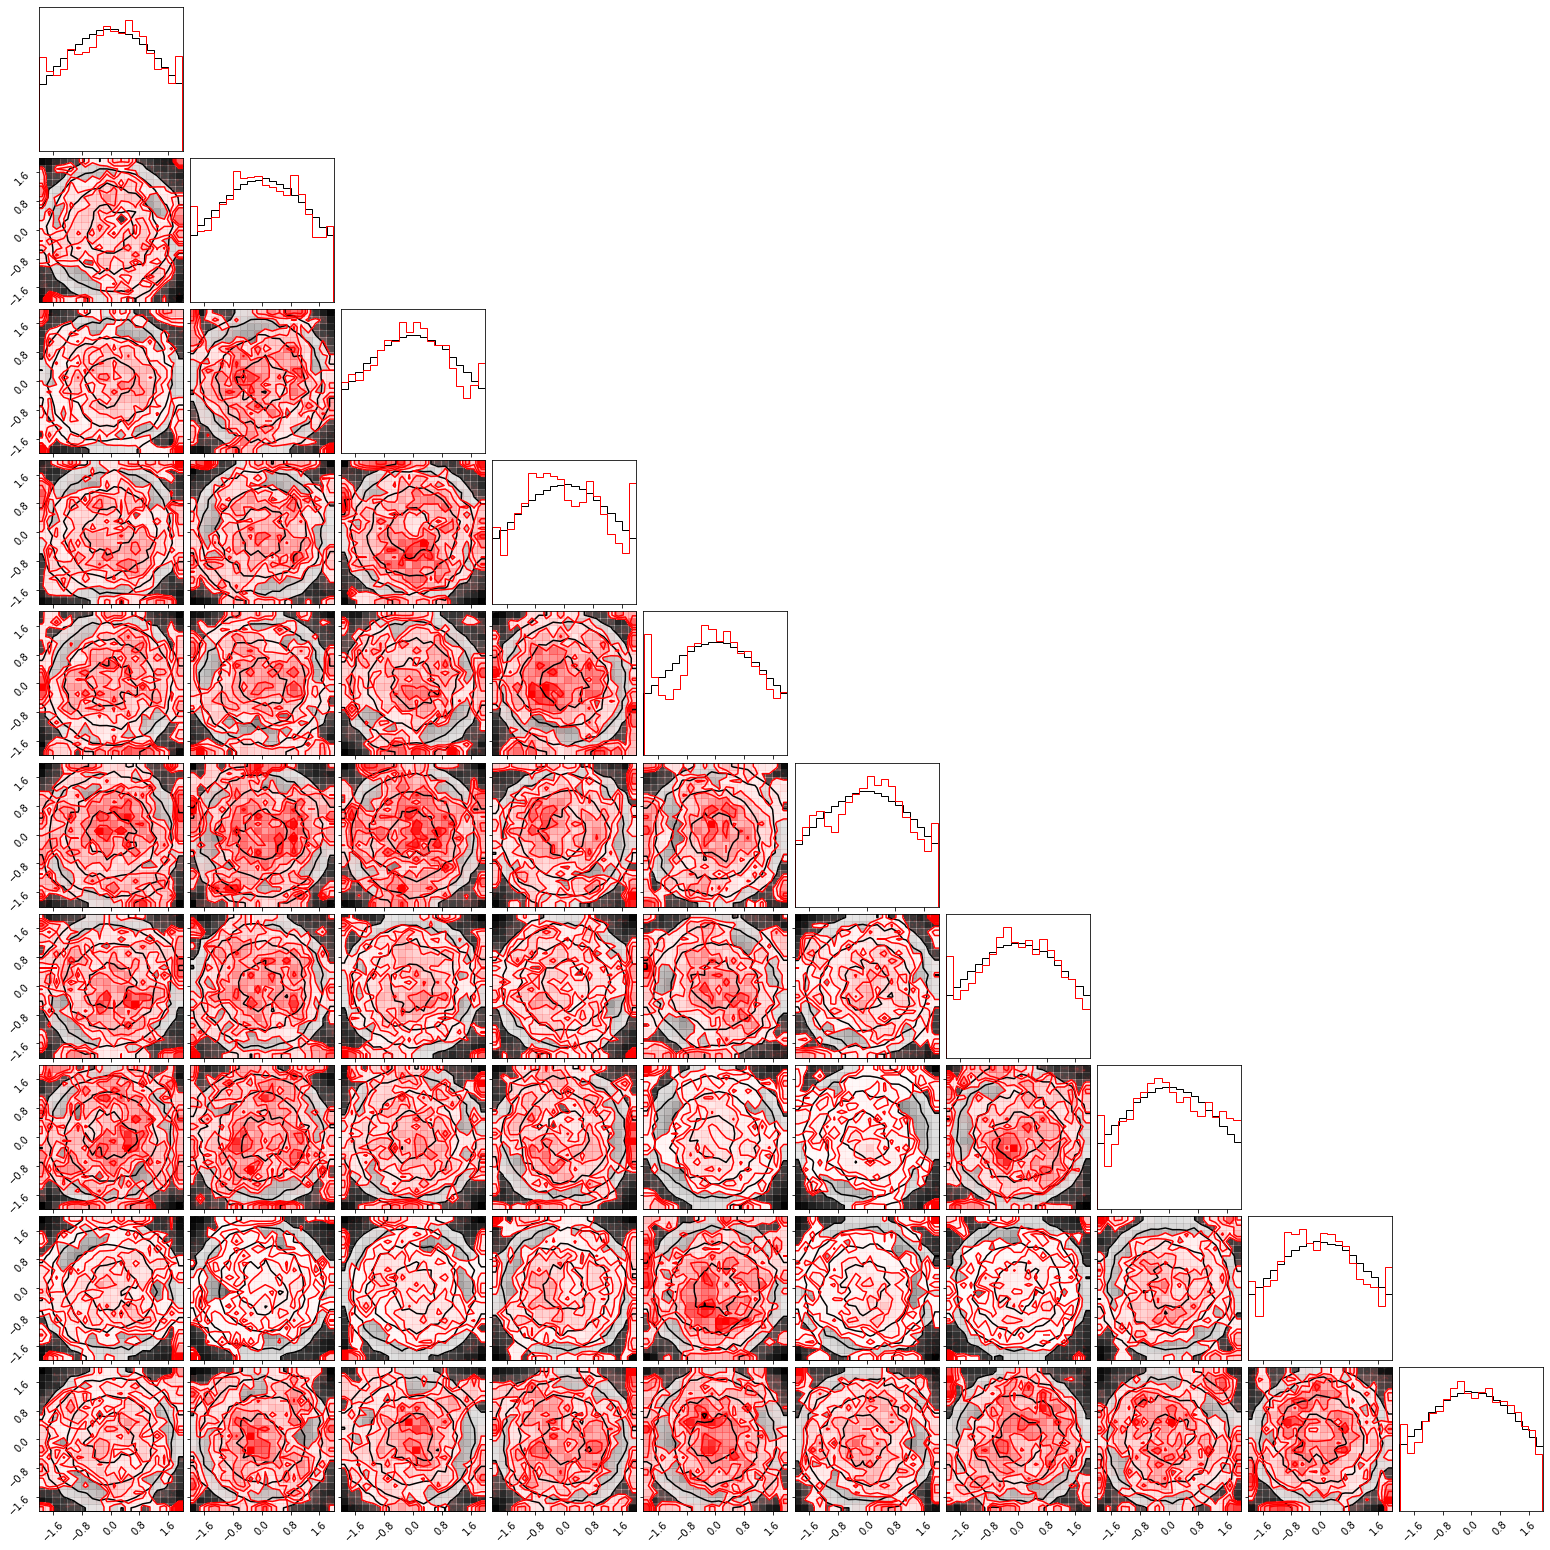

In [10]:
# %%capture
X1 = collect_samples(sampler1.history_path)
# fig1 = corner.corner(bounded_iid_samples[0:X1.shape[0]])
fig1 = corner.corner(bounded_iid_samples, hist_kwargs={'density':True})

# ground_truth_samples=model.newDrawFromPosterior(1000000)
corner.corner(X1, color='r', fig=fig1, hist_kwargs={'density':True})
fig1.savefig('bounded_gaussian_test.png')

In [ ]:
X1.shape[0]

## Run sSVN dynamics

In [ ]:
from scripts.plot_helper_functions import extract_velocity_norms, extract_gmlpt_norm
import matplotlib.pyplot as plt
norms = extract_velocity_norms(sampler1.history_path)
gmlpt_norm = extract_gmlpt_norm(sampler1.history_path)


In [ ]:
# Convergence criteria

fig, axs = plt.subplots(1, 3)
# axs[0].plot(model.fgrid, L1_response.squeeze())
axs[0].plot(norms['vsvn'])
axs[0].set_yscale('log')
axs[1].plot(norms['vsvgd'])
axs[1].set_yscale('log')
axs[2].plot(gmlpt_norm)
axs[2].set_yscale('log')







In [ ]:
plt.yscale('log')
plt.plot(norms['vsvn'])
plt.ylabel('Norm of SVGD vector')
plt.xlabel('Iteration')

# norms['vsvn']

In [ ]:
plt.yscale('log')
plt.plot(norms['v_svgd'])
plt.ylabel('Norm of SVGD vector')
plt.xlabel('Iteration')

In [ ]:
sampler2 = samplers(model=model, nIterations=100, nParticles=100, profile=False)
sampler2.apply(method='sSVN', eps=0.1)

In [ ]:
%%capture
X2 = collect_samples(sampler2.history_path)
fig2 = corner.corner(X2)

In [ ]:
corner.corner(ground_truth_samples[0:X2.shape[0]], fig=fig2)